# The grid as an object

In this notebook, the grid object and the xarray dataset and data frame are explained and demonstrated with a few illustrating examples. 

---

The module grid.py contains one class, `Grid()`. When we import the module, a few convenient variables are also generated. Most packages are imported with the module, but some rarely used dependencies are imported in functions when needed. More about this later. 

Dependencies: 

`basemap geopandas matplotlib numpy pyproj rasterio scipy xarray`

and for some functions:

`bokeh fiona holoviews imageio mayavi shapely `

We import grid: 

Comment Mar 2019: Don't worry about "yaml.load_all is unsafe" warning. https://github.com/dask/distributed/issues/2564

In [2]:
#Depending on where the grid.py is located, you might call it from its path

import sys
sys.path.append('..')

# ... or use your Python path or present working directory:
from agrid.agrid import *

# We also need some other useful functions
import agrid.accessories as grid_acc


print(Grid)
print(km) #-This is so handy! -You're welcome. 

#Check if some modules have been imported
print('numpy' in sys.modules, 
      'rasterio' in sys.modules, 
      'bokeh' in sys.modules, sep='\n') #(bokeh is imported in a method)

print(type(np), type(plt), type(xr)) # Use of standard aliases 

<class 'agrid.agrid.Grid'>
1000
True
True
False
<class 'module'> <class 'module'> <class 'module'>


We can now define a grid object. 

Each grid is a model frame with a defended, regular$^1$ spatial extent. The frame is generated when the object is initiated and resolution, coordinate system and coordinates are defined. 

The class defines an object. Let's say that we would like to develop a gridded model of the African continent. We want to use WGS 1984, EPSG:4326, and a resolution of $0.5^\circ$. We define the extent as left, right, up, down in the units of the projection, degrees in this example. 

When initiating the object, a number of instance variables are defined. These contains the size of the grid, the name of the grid and the affine transform of the grid. (`use_dask` will be explained later). 

---
1. This will updated in later versions. 

In [3]:
africa = Grid(crs=4326, left=-20, down= -45, right=55, up=40, 
              res = (0.5, 0.5), use_dask=False)

print(africa)

With the object, variables are generated, both class variables and instance variables. 

E.g the class variable verbose is a switch for print statements from the functions. Instance variables `nx`, `ny`, `nn`, `shape3` are integers and tuples that conveniently gives to fundamental size of the grid. `transform` is the affine transform. 

In [4]:
# Class variables
print(Grid.verbose) # Switch for print commands

# Instance variables
print(africa.ny, africa.nx, africa.nn, africa.shape3)
print(africa.transform)

False
169 149 (169, 149) (169, 149, 5)
| 0.50, 0.00,-20.00|
| 0.00,-0.50, 39.50|
| 0.00, 0.00, 1.00|


Note that dimensions are given as y, x, not x, y. This was a tricky decision to take. The reasoning is, that numpy arrays are given as rows-columns. By given the y dimension first, we are consistent through the project, but I'd expect that this might cause confusion. I'm happy for suggestions of how to simplify the indexing. Indexing is, however, less a problem when we move to the main feature of the grid object, the xarray dataset. 

---

Most important, and xarray dataset is created and it is already populated with dimensions that contains coordinates. X, Y and Z are (in this example) the three spatial dimensions. X and Y are set to the selected projection (epsg:4326) and is hence in degrees. 

Xarray dataset can be a bit tricky to grasp. There is good information at [xarray project page](http://xarray.pydata.org/en/stable/api.html) where there are a number of code examples. As always, [Stack overflow](https://stackoverflow.com/search?q=xarray) is a good resource as well. Think about it as Pandas, but multidimensional. It can also be understood as a very organized way to arrange numpy arrays in relation to each other. Another approach, if you are familiar with [NetCDF](https://www.unidata.ucar.edu/software/netcdf/), xarray has a similar internal structure. 

For our use, each grid object contains one dataset e.g. `africa.ds`. The dataset contains a number of data frames that are linked to coordinates in different dimensions. The dataset also contain attribute data. 

In [5]:
print(africa.ds)

<xarray.Dataset>
Dimensions:  (BAND: 4, X: 149, Y: 169, Z: 5)
Coordinates:
  * X        (X) float32 -20.0 -19.496622 -18.993244 ... 53.493244 53.99662 54.5
  * Y        (Y) float32 39.5 38.997025 38.49405 ... -43.99405 -44.497025 -45.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * BAND     (BAND) <U1 'B' 'A' 'N' 'D'
    XV       (Y, X) float32 -20.0 -19.496622 -18.993244 ... 53.99662 54.5
    YV       (Y, X) float32 39.5 39.5 39.5 39.5 39.5 ... -45.0 -45.0 -45.0 -45.0
    lat      (Y, X) float32 39.5 39.5 39.5 39.5 39.5 ... -45.0 -45.0 -45.0 -45.0
    lon      (Y, X) float32 -20.0 -19.496622 -18.993244 ... 53.99662 54.5
Data variables:
    *empty*


We use standard Python / numpy methods to generate or process data and assign to the dataset. Here we generate a 2D array of data points and assign it to the Y and X coordinates of the grid. 

In [6]:
random_data = np.random.random(africa.nn)
africa.ds['RANDOM'] = (('Y', 'X'), random_data)

The object contains a number of functions to import, process, export and visualize data in the grid. More about import functions in next tutorial. For now, we download a global polygon shape file. 

In [7]:
# Usning standard *nix: 

! mkdir -p ../../data/vector
! wget -nc http://data.openstreetmapdata.com/simplified-land-polygons-complete-3857.zip \
    -O ../../data/vector/simplified-land-polygons-complete-3857.zip
! unzip -n ../../data/vector/simplified-land-polygons-complete-3857.zip -d ../../data/vector

File ‘../../data/vector/simplified-land-polygons-complete-3857.zip’ already there; not retrieving.
Archive:  ../../data/vector/simplified-land-polygons-complete-3857.zip


The shape file can be used to generate a Boolean raster. The function `assign_shape` in the object ´africa´ reads a shape file and rasterises it. Here, all polygons are assigned `True` as there is an FID attribute. This might take some time, as the vector layer is very large. This will also generate some warnings, as no vector file is perfect... 

Note again, the order of dimension: Y, X. 

In [8]:
africa.ds['LAND'] = (('Y', 'X'), 
                     -1 < africa.assign_shape('../../data/vector/simplified-land-polygons-complete-3857/simplified_land_polygons.shp', 'FID') )

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Now, if we look at our dataset, we have two data variables, or frames. RANDOM and LAND. Both have an extent along the X and Y axes. 

In [9]:
africa.ds

<xarray.Dataset>
Dimensions:  (BAND: 4, X: 149, Y: 169, Z: 5)
Coordinates:
  * X        (X) float32 -20.0 -19.496622 -18.993244 ... 53.493244 53.99662 54.5
  * Y        (Y) float32 39.5 38.997025 38.49405 ... -43.99405 -44.497025 -45.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * BAND     (BAND) <U1 'B' 'A' 'N' 'D'
    XV       (Y, X) float32 -20.0 -19.496622 -18.993244 ... 53.99662 54.5
    YV       (Y, X) float32 39.5 39.5 39.5 39.5 39.5 ... -45.0 -45.0 -45.0 -45.0
    lat      (Y, X) float32 39.5 39.5 39.5 39.5 39.5 ... -45.0 -45.0 -45.0 -45.0
    lon      (Y, X) float32 -20.0 -19.496622 -18.993244 ... 53.99662 54.5
Data variables:
    RANDOM   (Y, X) float64 0.3039 0.3613 0.6357 0.2489 ... 0.1471 0.8185 0.7376
    LAND     (Y, X) bool False False False False ... False False False False

Xarray works similar to numpy, in many ways. Here are some examples of arithmetic and conditional computations. We will look closer at the `map_grid` function in later tutorial. 

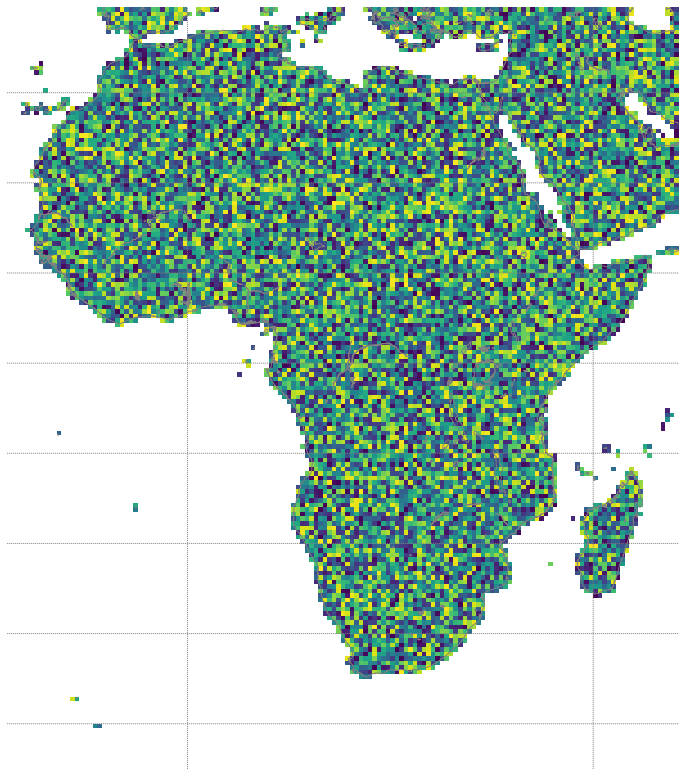

In [10]:
africa.ds['BIG_RANDOM'] = africa.ds['RANDOM'] * 2 

africa.ds['DATA'] = africa.ds['BIG_RANDOM']*africa.ds['LAND']

africa.ds['DATA'] = africa.ds['DATA'].where(africa.ds['DATA'] != 0.)  

africa.map_grid('DATA', cmap='viridis') # We only need to send the label to the function 

Xarray have a number option to index and select data. See details about the API at the [Xarray project page](http://xarray.pydata.org/en/stable/api.html). Here is a bunch of examples that hopefully explains the options: 

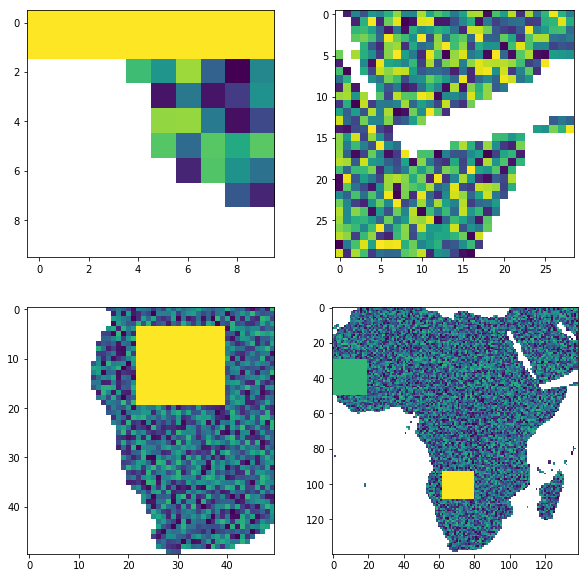

In [18]:
# Values can be assigned
africa.ds['DATA'][dict(X=slice(4, 30), Y=slice(40, 60))] = 2

#modify one grid point, using where() or loc()
africa.ds['DATA'] = xr.where((africa.ds.coords['lat']==-20)&(africa.ds.coords['lon']==30), 2, africa.ds['DATA'])

# Assign value to an area with a mask 
mask = (africa.ds.coords['lat']>-20)&(africa.ds.coords['lat']<-12)&(africa.ds.coords['lon']>16)&(africa.ds.coords['lon']<25)
africa.ds['DATA'] = xr.where(mask, 3, africa.ds['DATA'])

# Data by numpy index:
A =  africa.ds['DATA'][66, 33]

# Coord by index:
B = africa.ds.coords['lon'][66, 33]

# Data by coord using isel:
C = africa.ds['DATA'].isel(X=33, Y=66)

# Closest to coordinate values:
#http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html#xarray.Dataset.sel
D = africa.ds['DATA'].sel(X=[14.5, 71.32], method='nearest') 

# Or another coordinate set:
E = africa.ds.coords['lon'][66, 33]

# Use coordinates to select a slice from a data array:
F = africa.ds['DATA'][dict(X=slice(8, 18), Y=slice(58, 68))]

# Select 2D array from slices of coordinates from dict of indicies
G = africa.ds['DATA'][dict(X=slice(120, 150), Y=slice(40, 70))]

# Select 2D array from coordinate values
H = africa.ds['DATA'].sel(X=slice(5, 30), Y=slice(-10, -35))

I = africa.ds['DATA'][10:150,10:150]

fig, axes = plt.subplots(2,2, figsize=(10,10))
for ax, array in zip(axes.flatten(), [F, G, H, I]):
    ax.imshow(array)


plt.show()

This returned a cell of the entire dataset, but we can also extract numpy arrays and numbers by using a dictionary interface `values`: 

In [19]:
print(type(africa))
print(type(africa.ds))
print(type(africa.ds['DATA']))
print(type(africa.ds['DATA'].values))

<class 'agrid.agrid.Grid'>
<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>


Json is a handy format for transferring and store metadata:

In [20]:
# Add attribute data directely
africa.ds.attrs['units'] = 'degrees'
africa.ds.attrs['contact'] = 'mail@address.gh'

#Or as text, xml, json etc
import json
with open('attr.json', 'r') as fp:
    meta_data = json.loads(fp.read())

for item in meta_data.items():
    africa.ds.attrs[item[0]] = item[1]

Handy attributes to xarray dataset: 

In [21]:
print('Coords:')
print(africa.ds.coords)

print('Attributes, metadata:')
print(africa.ds.attrs)

print('Size in bytes:')
print(africa.ds.nbytes)

Coords:
Coordinates:
  * X        (X) float32 -20.0 -19.496622 -18.993244 ... 53.493244 53.99662 54.5
  * Y        (Y) float32 39.5 38.997025 38.49405 ... -43.99405 -44.497025 -45.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * BAND     (BAND) <U1 'B' 'A' 'N' 'D'
    XV       (Y, X) float32 -20.0 -19.496622 -18.993244 ... 53.99662 54.5
    YV       (Y, X) float32 39.5 39.5 39.5 39.5 39.5 ... -45.0 -45.0 -45.0 -45.0
    lat      (Y, X) float32 39.5 39.5 39.5 39.5 39.5 ... -45.0 -45.0 -45.0 -45.0
    lon      (Y, X) float32 -20.0 -19.496622 -18.993244 ... 53.99662 54.5
Attributes, metadata:
OrderedDict([('units', 'degrees'), ('contact', 'name.nameson@email.gh.com'), ('continent', 'Africa'), ('projection', 4326), ('name', 'Name Nameson')])
Size in bytes:
1033729


We use a function from the class to save. Returns size.  

In [22]:
africa.save(file_name='africa.nc')

1035016

In [23]:
!stat africa.nc  

16777220 8620593019 -rw-r--r-- 1 tobiasstal staff 0 1035016 "Mar 28 16:55:52 2019" "Mar 29 22:54:42 2019" "Mar 29 22:54:42 2019" "Jan 28 15:16:05 2019" 4194304 2024 0 africa.nc


Note that the module have very limited error handling, exceptions are raised by Python and the used models. 

In [24]:
africa.ds['NO_DATA_HERE']

# Raises: "if var_name is None: KeyError: 'NO_DATA'"

KeyError: 'NO_DATA_HERE'

Clear memory: 

In [25]:
#del africa 

Any problems? Check: 

In [26]:
! which Python3

/Library/Frameworks/Python.framework/Versions/3.6/bin/Python3
